‚òéÔ∏è In this notebook we will explore some phone calls obtained from two datasets:

- [`Call Friend`](https://ca.talkbank.org/access/CallFriend/)
- [`Call Home`](https://ca.talkbank.org/access/CallHome/)
    
Both have some different languages (unfortunatelly not Dutch) and audios are both in `wav` and `mp3`. In addition, you can have the transcriptions. 

Since I had a problem with one `wav` and `mp3` smaller than `wav` I'll download the `.mp3` files.

The steps that will be followed in this notebook are:

1. Download files from website 
2. Obtain audio features and build a dataframe with this information so we can have an idea of the necessary preprocessing before transcription
3. Perform transcription (both channels together and separate if possible to separate channels)
4. Perform sentiment analysis on the obtained transcription
5. Perform topic analysis

In [1]:
# importing packages

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

TodaysDate = time.strftime("%Y-%m-%d")

pd.options.display.max_rows = 999

In [2]:
def retrieve_hyperlinks(main_url):
    """ 
    Extract all hyperlinks in 'main_url' and return a list with these hyperlinks 
    """
    
    # Send request and catch response: r

    r = requests.get(main_url)

    # Extracts response as html: html_doc
    html_doc = r.text

    # Create a BeautifulSoup object from the HTML: soup
    soup = BeautifulSoup(html_doc)
    
    # Find all 'a' tags (which define hyperlinks): a_tags

    a_tags = soup.find_all('a')
    
    # Create a list with hyperlinks found

    list_links = [link.get('href') for link in a_tags]
    
    # Remove none values if there is some
    
    list_links = list(filter(None, list_links)) 
    
    return list_links

In [3]:
import urllib.request #download data from web

def dowload_file(url,filename, dest_folder):
    """ Download file from url and save in chosen folder"""
    
    # make request, i.e., download file

    urllib.request.urlretrieve(url+filename, dest_folder+filename)

In [4]:
from pydub import AudioSegment

def obtain_audio_attributes(filename, filefolder):
    """
    Show different audio attributes related to an audio file.
    
    Input: 
          filepath: complete path of an audio file
          
    Output:
        audio attributes of the audio file
    """
    # Create AudioSegment instance
    audio_segment = AudioSegment.from_file(filefolder+filename)
    
    # return some of the audio attributes
    
    return {'file_name': filename,
            'audio_type': filename.split('.')[-1],
            'number_of_channels': audio_segment.channels,
            'sample_width': audio_segment.sample_width,
            'frame_rate' : audio_segment.frame_rate,
            'frame_width' : audio_segment.frame_width,
            'duration_in_seconds' : audio_segment.duration_seconds}

In [5]:
import pandas as pd

def create_csv_audios_info(list_filenames, filefolder, dest_csv="../data/processed/"):
    
    dict_list = []
    
    # append all dictionaries with audio attributes in a list
    for file in list_filenames:
        result = obtain_audio_attributes(file, filefolder)
        
        dict_list.append(result)
        
    # Create a unique dictionary with info of all audios in list_filenames    
    new_dict = {}
    
    for key in result.keys():
        new_dict[key] = tuple(new_dict[key] for new_dict in dict_list)
    
    # Create a dataframe from new_dict
    
    df = pd.DataFrame(new_dict)
    
    # save dataframe as csv
    
    df.to_csv(dest_csv+"info_audio_files.csv", index_label=False)
    
    return df

# Audio files CallHome

In [6]:
audios_call_home = 'https://media.talkbank.org/ca/CallHome/eng/'

In [7]:
# retrieve all hyperlinks in the page
main_url = audios_call_home
list_hyperlinks = retrieve_hyperlinks(main_url)

# filter to obtain only hyperlinks for audios
list_audio_call_home = [item for item in list_hyperlinks if '.mp3' in item]

In [8]:
len(list_audio_call_home)

176

There are 176 calls in English at `CallHome`.

# Accessing Audio files CallFriend

In [9]:
audios_call_friend = 'https://media.talkbank.org/ca/CallFriend/eng-n/'

In [10]:
# retrieve all hyperlinks in the page
main_url = audios_call_friend
list_hyperlinks = retrieve_hyperlinks(main_url)

# filter to obtain only hyperlinks for audios
list_audio_call_friend = [item for item in list_hyperlinks if '.mp3' in item]

In [11]:
len(list_audio_call_friend)

31

## Download audio files

Since we have a limitation of how long and how many transcriptions can be performed per day we will work with `CallFriend` dataset.

Let's download audio files from CallFriend website.

At `CallFriend` we have 31 calls. Let's download these 31.

In [12]:
for filename in list_audio_call_friend:
    dowload_file(audios_call_friend,filename,"../data/audio_call_friend/")

Now, let's collect some information about these audios.

In [13]:
df_call_friend = create_csv_audios_info(list_audio_call_friend, filefolder="../data/audio_call_friend/", dest_csv="../data/processed/")

In [14]:
df_call_friend.head()

file_name audio_type  number_of_channels  sample_width  frame_rate  \
0  4175.mp3        mp3                   2             2        8000   
1  4504.mp3        mp3                   2             2        8000   
2  4708.mp3        mp3                   2             2        8000   
3  4745.mp3        mp3                   2             2        8000   
4  4823.mp3        mp3                   2             2        8000   

   frame_width  duration_in_seconds  
0            4             1799.928  
1            4              470.664  
2            4             1799.928  
3            4             1425.384  
4            4             1799.928

In [15]:
df_call_friend['duration_in_minutes'] = df_call_friend['duration_in_seconds']/60.0

In [16]:
df_call_friend.head()

file_name audio_type  number_of_channels  sample_width  frame_rate  \
0  4175.mp3        mp3                   2             2        8000   
1  4504.mp3        mp3                   2             2        8000   
2  4708.mp3        mp3                   2             2        8000   
3  4745.mp3        mp3                   2             2        8000   
4  4823.mp3        mp3                   2             2        8000   

   frame_width  duration_in_seconds  duration_in_minutes  
0            4             1799.928              29.9988  
1            4              470.664               7.8444  
2            4             1799.928              29.9988  
3            4             1425.384              23.7564  
4            4             1799.928              29.9988

In [17]:
df_call_friend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   file_name            31 non-null     object 
 1   audio_type           31 non-null     object 
 2   number_of_channels   31 non-null     int64  
 3   sample_width         31 non-null     int64  
 4   frame_rate           31 non-null     int64  
 5   frame_width          31 non-null     int64  
 6   duration_in_seconds  31 non-null     float64
 7   duration_in_minutes  31 non-null     float64
dtypes: float64(2), int64(4), object(2)
memory usage: 2.1+ KB


In [18]:
df_call_friend.describe()

number_of_channels  sample_width  frame_rate  frame_width  \
count                31.0          31.0        31.0         31.0   
mean                  2.0           2.0      8000.0          4.0   
std                   0.0           0.0         0.0          0.0   
min                   2.0           2.0      8000.0          4.0   
25%                   2.0           2.0      8000.0          4.0   
50%                   2.0           2.0      8000.0          4.0   
75%                   2.0           2.0      8000.0          4.0   
max                   2.0           2.0      8000.0          4.0   

       duration_in_seconds  duration_in_minutes  
count            31.000000            31.000000  
mean           1615.220129            26.920335  
std             393.531090             6.558851  
min             470.664000             7.844400  
25%            1689.912000            28.165200  
50%            1799.928000            29.998800  
75%            1799.928000            29.998800  
max            1799.928000            29.998800

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

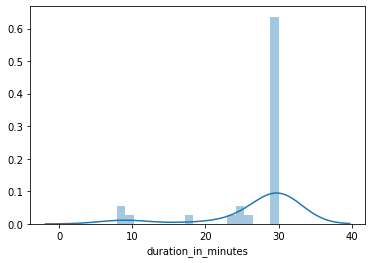

In [20]:
sns.distplot(df_call_friend['duration_in_minutes'])

From the statistical summary we can conclude somethings:

1. All calls are stereo, i.e., have two channels which means we can isolate each caller to transcript.
2. The frequency of all calls are 8kHz which implies probably not so good quality but we can use `set_frame_rate` to change to 16kB.
3. Most of the calls used the 30 min of free call. Only one person talked less than 8 min.

In [21]:
df_call_friend[df_call_friend['duration_in_minutes']<=8]

file_name audio_type  number_of_channels  sample_width  frame_rate  \
1  4504.mp3        mp3                   2             2        8000   

   frame_width  duration_in_seconds  duration_in_minutes  
1            4              470.664               7.8444

In [22]:
filefolder="../data/audio_call_friend/"
audio_segment = AudioSegment.from_file(filefolder+"4504.mp3")
audio_segment

üò≥  I think it will be difficult to transcribe this one ü§£

continue ...